# Sekwencyjny model CNN z Keras i bazą CIFAR10
W tym zeszycie używam bazy danych CIFAR10

Tym razem kod jest dla maszyny ze wsparcien GPU, ponieważ udało mi się wreszcie nabyć karty obsługujące technologię CUDA - ogólnie rzecz biorąc na chwilę obecną zajmuje się tym chyba wyłącznie NVIDIA, ale konkurencja nie śpi, także polecam się w razie czego rozejrzeć.

In [1]:
# Nie musisz mówić Kerasowi, że ma używać GPU. Sam się połapie. 
# Jak na razie to najlepszy model jaki udało mi się zrobić. W 5 epok wyciąga około 75% bez overfittingu.

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
#from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model
import os


Using TensorFlow backend.


In [2]:
# Podstawowe zmienne wyciągnięte na wierzch
batch_size = 32 # 16 dla dużych obrazków - 32 dla większych bo inaczej Ci się Kernel w Jupyterze zcrashuje.
num_classes = 10 # Ilość kategorii - CIFAR ma 10. Dwa pojazdy i 8 zwierząt.
epochs = 5

# Wczytaj CIFAR10 <- Inny sposób ładowania bazy danych - za pomocą x i y a nie wyznaczonych ścieżek jak w Keras_Nb_2
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Zwizualizuj wymiary(kształt) naszych danych
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Sformatuj dane poprzez Normalizację i zmianę typów
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# One-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape:  (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
# Zauważ różnicę w sposobie dodawania aktywacji (poza warstwą). Nie jest to niewłaściwe. Po prostu tak też można. :)
model = Sequential()
# Padding = 'same' powoduje wyrównanie wejść i wyjść do tej samej długości.
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu')) 
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Wartości dropoutu są chyba najlepsze z możliwych...

model.add(Conv2D(64, (3, 3), padding='same')) # Dodawanie warstw lub zmienianie kompozycji (dzielenie na mniejsze) obniża skuteczność modelu. 
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35)) 
          
model.add(Flatten())
model.add(Dense(2048, activation='relu')) # Zacząłem od 512. Lepiej przy 2048. Więcej nie ma sensu a wręcz spada.
model.add(Dropout(0.5)) # Nie dawaj wyższych wartości końcowych 'dropout' niż 0.5, chyba, że wiesz co robisz...

# Sposób aktywacji ostatniej warstwy inny niż na przykładzie wyjściowym, 
# bo mam 10 kategorii, więc lepiej wziąć softmax. Dla dwóch końcowych (albo-albo) byłby Sigmoid.
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#Tutaj warto poeksperymentować z metodą optymalizacji:          
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6) <= Adam jest jak zwykle lepszy...
opt = 'adam'          

# Sposób kalkulowania straty. Właściwy dla 10 kategorii.
model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [4]:
# Trening modelu
history = model.fit(x_train, y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True)
    
model.save("/home/g-man/repozytoria/ai/research_process/trainedmodels/cifar_cnn_3.h5")

# Ewaluacja modelu
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])


Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 14s 290us/step - loss: 1.4377 - acc: 0.4782 - val_loss: 1.0963 - val_acc: 0.6129
Epoch 2/5
50000/50000 [==============================] - 12s 246us/step - loss: 1.0608 - acc: 0.6235 - val_loss: 0.8892 - val_acc: 0.6937
Epoch 3/5
50000/50000 [==============================] - 12s 247us/step - loss: 0.9093 - acc: 0.6801 - val_loss: 0.7867 - val_acc: 0.7240
Epoch 4/5
50000/50000 [==============================] - 12s 247us/step - loss: 0.8147 - acc: 0.7141 - val_loss: 0.7583 - val_acc: 0.7381
Epoch 5/5
10000/10000 [==============================] - 0s 49us/step
Test loss:  0.7221145270347595
Test accuracy:  0.7495


## Wizualizacja uczenia się modelu
Zobaczymy czy, na ile i w którym miejscu mamy overfitting

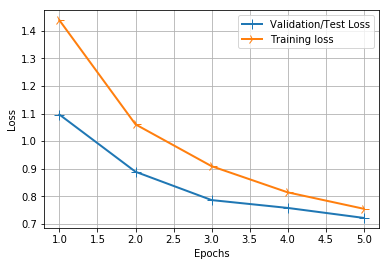

In [8]:
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
#Poniżej funkcja straty w czasie dla powyższego modelu.

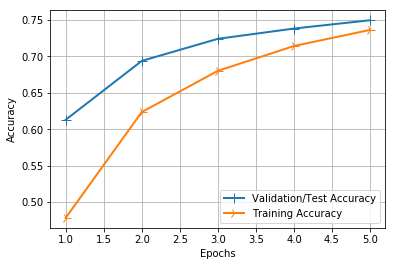

In [7]:
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()
# Poniżej trafność w czasie dla powyższego modelu.

## Zapisujemy nasz model
Zmień na pełną ścieżkę docelową na swoim komputerze.
Uważaj, żeby folder faktycznie istniał, bo program nie stworzy ścieżek automatycznie.

In [14]:
model.save("/home/g-man/repozytoria/ai/research_process/trainedmodels/cifar_cnn2.h5")
print('Model Saved')

Model Saved


## Wczytujemy model
To trochę bardziej skomplikowane, bo Keras musi teraz wszystko rozpakować.

In [15]:
from keras.models import load_model

classifier = load_model('/home/g-man/repozytoria/ai/research_process/trainedmodels/cifar_cnn2.h5')

## Testujemy Model

In [ ]:
import cv2
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 32, 32, 3
classifier = load_model("/home/g-man/repozytoria/ai/research_process/trainedmodels/cifar_cnn_2.h5")
color = True
scale = 8

def draw_test(name, res, input_im, scale, img_row, img_height):
    BLACK = [0,0,0]
    res = int(res)
    if res == 0:
        pred = 'samolot'
    if res == 1:
        pred = 'samochod'
    if res == 2:
        pred = 'ptak'
    if res == 3:
        pred = 'kot'
    if res == 4:
        pred = 'jelen'
    if res == 5:
        pred = 'pies'        
    if res == 6:
        pred = 'zaba'
    if res == 7:
        pred = 'kon'        
    if res == 8:
        pred = 'statek'
    if res == 9:
        pred = 'ciezarowka'        
        
    expanded_image = cv2.copyMakeBorder(input_im, 0, 0, 0, imageL.shape[0]*2 ,cv2.BORDER_CONSTANT,value=BLACK)
    if color == False:
        expanded_image = cv2.cvtColor(expanded_image, cv2.COLOR_GRAY2BGR)
    cv2.putText(expanded_image, str(pred), (300,80) , cv2.FONT_HERSHEY_COMPLEX_SMALL,3, (0,255,0), 2)
    cv2.imshow(name, expanded_image)
    
for i in range(0,10):
    rand = np.random.randint(0,len(x_test))
    input_im = x_test[rand]
    imageL = cv2.resize(input_im, None, fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC)
    input_im = input_im.reshape(1,img_row, img_height, img_depth)
    
    # Opisuje co widzi
    res = str(classifier.predict_classes(input_im, 1 , verbose = 0)[0])
    
    draw_test("Prediction", res, imageL, scale, img_row, img_height)
    cv2.waitKey(0)
    
cv2.destroyAllWindows()
    